# Correlation Analysis and Feature Engineering

This notebook converts key categorical variables into ordinal encodings, engineers composite features that capture socioeconomic status and student effort, and runs a correlation analysis to assess which numeric features best predict `avg_score`. The engineered dataset will serve as the input for all downstream models in NB05 and NB06.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('ExpandedScoresData_Cleaned.csv')

In [2]:
# examine the dataframe
df.head()

,gender,ethnicity,parental_education,lunch_type,test_prep,parent_marital_status,practice_sports,first_child,num_siblings,transport_means,weekly_study_hours,math_score,reading_score,writing_score,avg_score
0,female,unknown,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74,72.000000
1,female,group C,some college,standard,unknown,married,sometimes,yes,0.0,unknown,5 - 10,69,90,88,82.333333
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91,90.333333
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,unknown,5 - 10,45,56,42,47.666667
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75,76.333333


In [3]:
# examine the columns
df.columns.tolist()

['gender',
 'ethnicity',
 'parental_education',
 'lunch_type',
 'test_prep',
 'parent_marital_status',
 'practice_sports',
 'first_child',
 'num_siblings',
 'transport_means',
 'weekly_study_hours',
 'math_score',
 'reading_score',
 'writing_score',
 'avg_score']

Parental education has a clear natural ordering from 'some high school' through to 'master's degree'. An ordinal encoding maps each level to a numeric value (0–6), enabling it to be used in correlation matrices and as a continuous feature in linear models.

In [4]:
parent_ed_map = {
    'unknown': 0,
    'some high school': 1,
    'high school': 2,
    'some college': 3,
    "associate's degree": 4,
    "bachelor's degree": 5,
    "master's degree": 6
}

df['parent_ed_ordinal'] = df['parental_education'].map(parent_ed_map).astype(float)

assert df['parent_ed_ordinal'].notna().all(), \
    f"parent_ed_map is incomplete — unmapped values: {df[df['parent_ed_ordinal'].isna()]['parental_education'].unique()}"

print("dtype:", df['parent_ed_ordinal'].dtype) #this is now a float, making it easier to work with numerically
print("sample:", df['parent_ed_ordinal'].head())
print("\ndistribution:")
print(df['parent_ed_ordinal'].value_counts().sort_index())


dtype: float64
sample: 0    5.0
1    3.0
2    6.0
3    4.0
4    3.0
Name: parent_ed_ordinal, dtype: float64

distribution:
parent_ed_ordinal
0.0    1845
1.0    5517
2.0    5687
3.0    6633
4.0    5550
5.0    3386
6.0    2023
Name: count, dtype: int64


With `parent_ed_ordinal` in place, the same ordinal treatment is applied next to `weekly_study_hours`, which is similarly bucketed from unknown (0) through > 10 hours (3).

Study hours have 4 levels and can be mapped from a 0-3 scale

In [5]:
study_map = {
    'unknown': 0,
    '< 5': 1,
    '5 - 10': 2,
    '> 10': 3
}

df['study_hours_ordinal'] = df['weekly_study_hours'].map(study_map).astype(float)

assert df['study_hours_ordinal'].notna().all(), \
    f"study_map is incomplete — unmapped values: {df[df['study_hours_ordinal'].isna()]['weekly_study_hours'].unique()}"

print("dtype:", df['study_hours_ordinal'].dtype) #this is now a float, making it easier to work with numerically
print("sample:", df['study_hours_ordinal'].head())
print("\ndistribution:")
print(df['study_hours_ordinal'].value_counts().sort_index())

dtype: float64
sample: 0    1.0
1    2.0
2    1.0
3    2.0
4    2.0
Name: study_hours_ordinal, dtype: float64

distribution:
study_hours_ordinal
0.0      955
1.0     8238
2.0    16246
3.0     5202
Name: count, dtype: int64


Both ordinal columns (`parent_ed_ordinal` and `study_hours_ordinal`) are now ready for use in the correlation matrix later in this notebook and as continuous inputs to the linear models in NB05 and NB06.

The previous notebooks found strong, consistent effects from both lunch type and parental education — the two largest single-factor gaps in NB02. Both act as proxies for socioeconomic status. Combining them into a three-tier composite (`ses_proxy`) captures their joint effect in a single feature.

In [6]:
def ses_proxy(row):
    lunch_low  = row['lunch_type'] == 'free/reduced'
    lunch_high = row['lunch_type'] == 'standard'
    ed_low  = row['parent_ed_ordinal'] <= 2  # unknown / some high school / high school
    ed_high = row['parent_ed_ordinal'] >= 5  # bachelor's or master's degree

    has_low  = lunch_low  or ed_low
    has_high = lunch_high or ed_high

    if has_low and has_high:   # conflicting signals → mid
        return 'mid_ses'
    elif has_low:
        return 'low_ses'
    elif has_high:
        return 'high_ses'
    else:
        return 'mid_ses'  # no signal (fallback; shouldn't occur with binary lunch_type)

df['ses_proxy'] = df.apply(ses_proxy, axis=1)
print("Socioeconomic status (SES) proxy distribution:")
print(df['ses_proxy'].value_counts())
print("\nCross-check (low_ses avg score):")
print(df[df['ses_proxy']=='low_ses']['avg_score'].mean().round(2))

Socioeconomic status (SES) proxy distribution:
ses_proxy
high_ses    11367
mid_ses     10481
low_ses      8793
Name: count, dtype: int64

Cross-check (low_ses avg score):
60.73


Next, `test_prep` and `study_hours_ordinal` are combined to create a student effort indicator, capturing whether overall effort level has any effect on performance.

In [7]:
df['effort_level'] = np.where(
    (df['test_prep'] == 'completed') & (df['study_hours_ordinal'] >= 2),
    'high_effort',
    np.where(
        (df['test_prep'] == 'none') & (df['study_hours_ordinal'] <= 1),
        'low_effort',
        'mid_effort'
    )
)

print("Effort level distribution:")
print(df['effort_level'].value_counts())
print("\nCross-check (high_effort avg score):")
print(df[df['effort_level']=='high_effort']['avg_score'].mean().round(2))

Effort level distribution:
effort_level
mid_effort     18078
high_effort     6937
low_effort      5626
Name: count, dtype: int64

Cross-check (high_effort avg score):
73.33


Math vs. reading/writing score gaps are computed per student. Negative values indicate a student scores lower in math than in verbal subjects — the typical pattern in this dataset (median gap: −2 to −3 points). These features capture subject-specific strengths independently of overall performance level and will serve as useful predictors in regression models.

In [8]:
df['math_writing_gap'] = df['math_score'] - df['writing_score']
df['math_reading_gap'] = df['math_score'] - df['reading_score']
print("Gap statistics:")
print(df[['math_writing_gap', 'math_reading_gap']].describe())

Gap statistics:
       math_writing_gap  math_reading_gap
count      30641.000000      30641.000000
mean          -1.860220         -2.819131
std            9.566833          9.108742
min          -33.000000        -34.000000
25%           -9.000000         -9.000000
50%           -2.000000         -3.000000
75%            5.000000          4.000000
max           31.000000         28.000000


Here, we can see that the majority of students score worse on math compared to reading and writing. The medians for both of these scores are -2 for writing and -3 for reading. 

In [9]:
# Creating quantile-based bins for avg_score
df['perf_tier'] = pd.qcut(df['avg_score'], q=3, labels=['low','medium','high'])
print('Performance tiers:')
print(df['perf_tier'].value_counts())
print('\nTier means:')
print(df.groupby('perf_tier', observed=True)['avg_score'].mean())

Performance tiers:
perf_tier
low       10465
high      10092
medium    10084
Name: count, dtype: int64

Tier means:
perf_tier
low       52.273387
medium    68.593217
high      84.073953
Name: avg_score, dtype: float64


This separates the population into three groups of similar sizes. We can also see the averages within each group. 

In [10]:
df.head(10)

,gender,ethnicity,parental_education,lunch_type,test_prep,parent_marital_status,practice_sports,first_child,num_siblings,transport_means,...,reading_score,writing_score,avg_score,parent_ed_ordinal,study_hours_ordinal,ses_proxy,effort_level,math_writing_gap,math_reading_gap,perf_tier
0,female,unknown,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,...,71,74,72.000000,5.0,1.0,high_ses,low_effort,-3,0,medium
1,female,group C,some college,standard,unknown,married,sometimes,yes,0.0,unknown,...,90,88,82.333333,3.0,2.0,high_ses,mid_effort,-19,-21,high
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,...,93,91,90.333333,6.0,1.0,high_ses,low_effort,-4,-6,high
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,unknown,...,56,42,47.666667,4.0,2.0,low_ses,mid_effort,3,-11,low
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,...,78,75,76.333333,3.0,2.0,high_ses,mid_effort,1,-2,high
5,female,group B,associate's degree,standard,none,married,regularly,yes,1.0,school_bus,...,84,79,78.666667,4.0,2.0,high_ses,mid_effort,-6,-11,high
6,female,group B,some college,standard,completed,widowed,never,no,1.0,private,...,93,89,89.000000,3.0,2.0,high_ses,high_effort,-4,-8,high
7,male,group B,some college,free/reduced,none,married,sometimes,yes,1.0,private,...,43,39,41.000000,3.0,3.0,low_ses,mid_effort,2,-2,low
8,male,group D,high school,free/reduced,completed,single,sometimes,no,3.0,private,...,64,68,65.666667,2.0,3.0,low_ses,high_effort,-3,1,medium
9,female,group B,high school,free/reduced,none,married,regularly,yes,2.0,private,...,59,50,48.666667,2.0,1.0,low_ses,low_effort,-13,-22,low


In [11]:
numeric_cols = ['math_score', 'reading_score', 'writing_score',
                'avg_score', 'parent_ed_ordinal', 'study_hours_ordinal',
                'math_writing_gap', 'math_reading_gap', 'num_siblings']


corr_matrix = df[numeric_cols].corr()
print(corr_matrix)

                     math_score  reading_score  writing_score  avg_score  \
math_score             1.000000       0.817825       0.807118   0.920061   
reading_score          0.817825       1.000000       0.952584   0.969337   
writing_score          0.807118       0.952584       1.000000   0.966292   
avg_score              0.920061       0.969337       0.966292   1.000000   
parent_ed_ordinal      0.165779       0.176123       0.210880   0.193777   
study_hours_ordinal    0.078884       0.044395       0.049993   0.060860   
math_writing_gap       0.302803      -0.224541      -0.318275  -0.082507   
math_reading_gap       0.361343      -0.241070      -0.182298  -0.018967   
num_siblings          -0.001084      -0.000796      -0.002375  -0.001501   

                     parent_ed_ordinal  study_hours_ordinal  math_writing_gap  \
math_score                    0.165779             0.078884          0.302803   
reading_score                 0.176123             0.044395         -0.224541

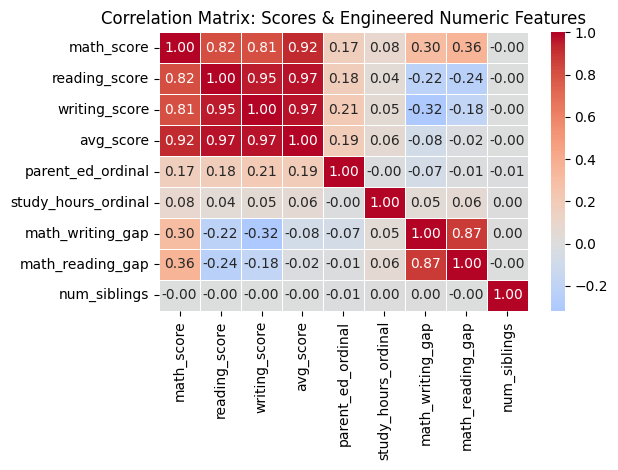

In [12]:
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix: Scores & Engineered Numeric Features')
plt.tight_layout()
plt.show()

As seen from the correlation heatmap index above, all scores are strongly correlated, confirming that the avg_score is a stable modeling target. <br>
`parent_ed_ordinal` has a moderate positive correlation with the scores, consistent with earlier gap analysis <br>
`study_hours_ordinal` has weaker but positive correlation, matching the small gap seen earlier. <br>
`num_siblings` has zero correlation with the scores, supporting it's low importance <br>
The math reading gap and the math writing gap are very strongly correlated, suggesting that students who perform better in one language metric perform better in the other as compared to math. 

The two engineered categorical proxy columns (`ses_proxy`, `effort_level`) are designed for tree models that handle categories natively. `perf_tier` (quantile-based low/medium/high tiers) enables classification-style analysis in NB05. The ordinal encodings (`parent_ed_ordinal`, `study_hours_ordinal`) are primarily used for correlation analysis and as continuous inputs to linear models.

In [13]:
# saving the DataFrame to CSV to carry forward engineered features
df.to_csv('ExpandedScoresData_Engineered.csv', index=False)

## Notebook Summary

This notebook created ordinal encodings and engineered composite features to prepare the dataset for modeling.

**Ordinal encodings created:**
- `parent_ed_ordinal`: parental education mapped to a 0–6 integer scale
- `study_hours_ordinal`: weekly study hours mapped to a 0–3 integer scale

**Composite features engineered:**
- `ses_proxy`: combines lunch type and parental education into a three-tier socioeconomic proxy (high / mid / low)
- `effort_level`: combines test prep completion and study hours into a three-tier effort indicator (high / mid / low)
- `math_writing_gap`, `math_reading_gap`: per-student subject-strength gaps, capturing how a student's math performance relates to their verbal performance

**Correlation analysis highlights:**
- All three scores are highly intercorrelated (r ≈ 0.82–0.95), confirming `avg_score` is a stable and representative regression target
- `parent_ed_ordinal` has a moderate positive correlation with scores (r ≈ 0.19), consistent with the ~11-point gap found in NB02
- `study_hours_ordinal` has a weak but positive correlation (r ≈ 0.06)
- `num_siblings` has near-zero correlation — consistent with its low-gap ranking in NB02

The engineered dataset is saved to `ExpandedScoresData_Engineered.csv` for use in NB05 and NB06.